In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import json
import os
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import platform
import pathlib
import zipfile

Loading our dataset

In [53]:
#loading dataset dict with ingredients, instructions
def load_dataset(ingredients_path,steps_path):

    with open(ingredients_path) as json_file: 
        ingredients = json.load(json_file)

    with open(steps_path) as json_file: 
        steps = json.load(json_file) 

    dataset = []
    ingredient_list = []

    for i in range(len(steps)):
      recipe = {}
      recipe['instructions'] = steps[i]['steps'].split(';')

      if ingredients[i]['recipe_id'] == steps[i]['recipe_id']:
        recipe['ingredients'] = []
        for li in ingredients[i]['tags']:
          if li[1] == 'ingredient':
            recipe['ingredients'].append(li[0])
            ingredient_list.append(li[0])

      #validating data
      if len(recipe['instructions']) != 0 and len(recipe['ingredients']) != 0:
          dataset.append(recipe)

    return dataset, ingredient_list

In [54]:
steps_path = '/content/drive/My Drive/Recipe Data/clean_recipies.json'
ingredients_path = '/content/drive/My Drive/Recipe Data/tagged_recipies_3_layer.json'

dataset, ingredients = load_dataset(ingredients_path,steps_path)

In [5]:
dataset[0]

{'ingredients': ['water',
  'lentils',
  'tomato',
  'carrot',
  'onion',
  'garlic',
  'chicken_bouillon',
  'lentils',
  'lentil',
  'mixture',
  'water',
  'cumin',
  'sea_salt',
  'pepper',
  'coriander',
  'soup'],
 'instructions': ['place 3 cups water , lentils , tomato , carrot , onion , garlic , and chicken bouillon in a stockpot over medium heat ',
  ' cook until vegetables and lentils are softened , 20 to 25 minutes . remove from heat and cool to lukewarm . blend vegetable and lentil mixture with an immersion blender until smooth . stir 1 cup water , cumin , sea salt , pepper , and coriander into soup ',
  ' heat over medium heat until warmed .']}

In [6]:
print('Total number of recipes: ',len(dataset))

Total number of recipes:  156097


Preprocessing

In [7]:
STOP_WORD_INGREDIENTS = '\n\nINGREDIENTS\n\n'
STOP_WORD_INSTRUCTIONS = '\n\nINSTRUCTIONS\n\n'

def stringify_recipe(recipe):
    ingredients_string = STOP_WORD_INGREDIENTS
    for ingredient in recipe['ingredients']:
        ingredients_string += f'• {ingredient}\n'

    instruction_string = STOP_WORD_INSTRUCTIONS
    for instruction in recipe['instructions']:
        instruction_string += f'•{instruction}\n'

    recipe_string = ingredients_string + instruction_string
    return recipe_string

In [8]:
dataset_strings = [stringify_recipe(recipe) for recipe in dataset]

In [9]:
print(dataset_strings[20])



INGREDIENTS

• parchment_paper
• flour
• salt
• milk
• oil
• dough
• dough
• dough
• dough


INSTRUCTIONS

•preheat oven to 375 degrees f . line a baking sheet with parchment paper . whisk flour and salt together in a bowl 
• form a well in the center . add milk and oil 
• mix until smooth dough forms . turn dough out onto a lightly floured work surface 
• knead until smooth and pliable , 10 to 15 minutes . set dough aside to rest for 15 minutes . divide dough into 4 equal pieces 
• roll out each piece with a rolling pin to 1/4 inch thickness . arrange on prepared baking sheet . bake in the preheated oven until lightly browned , 8 to 10 minutes .



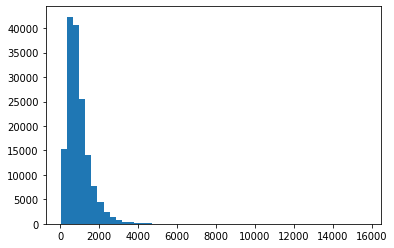

In [10]:
recipes_lengths = []
for recipe in dataset_strings:
    recipes_lengths.append(len(recipe))

plt.hist(recipes_lengths, bins=50)
plt.show()

In [11]:
#filtering out long recipes
MAX_RECIPE_LENGTH = 2000

def filter_recipes(recipe):
    if len(recipe) <= MAX_RECIPE_LENGTH:
        return True

dataset_filtered = [recipe for recipe in dataset_strings if filter_recipes(recipe)]

print('Number of eliminated recipes: ', len(dataset_strings) - len(dataset_filtered))

Number of eliminated recipes:  9015


In [12]:
print('lenght of filtered dataset: ', len(dataset_filtered))
TOTAL_RECIPES_NUM = len(dataset_filtered)

lenght of filtered dataset:  147082


creating vocab

In [13]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level=True,
    filters='',
    lower=False,
    split=''
)

tokenizer.fit_on_texts(dataset_filtered)
STOP_SIGN = '␣'
tokenizer.fit_on_texts([STOP_SIGN])
tokenizer.get_config()

{'char_level': True,
 'document_count': 147083,
 'filters': '',
 'index_docs': '{"22": 142735, "19": 146434, "20": 144803, "21": 147015, "29": 147082, "43": 147082, "7": 147038, "14": 146639, "12": 146732, "27": 141821, "25": 139002, "4": 147039, "23": 144423, "46": 76852, "44": 82058, "28": 147082, "31": 147082, "6": 147057, "24": 139540, "38": 82738, "37": 86836, "39": 147082, "32": 122173, "8": 147058, "16": 147082, "1": 147082, "10": 146918, "3": 147047, "11": 147082, "2": 147064, "33": 103184, "40": 147082, "9": 147049, "35": 147082, "15": 146354, "34": 147082, "42": 147082, "18": 146240, "41": 147082, "36": 98403, "5": 147026, "30": 147082, "13": 146961, "17": 145391, "26": 135779, "48": 42951, "49": 56641, "55": 16251, "45": 61319, "50": 46026, "47": 44686, "52": 20197, "57": 11862, "53": 13360, "51": 24525, "65": 437, "71": 249, "98": 32, "83": 73, "56": 5443, "54": 15259, "68": 410, "58": 7173, "72": 133, "86": 60, "62": 1038, "70": 277, "74": 215, "61": 1212, "64": 612, "89":

In [14]:
VOCABULARY_SIZE = len(tokenizer.word_counts) + 1
print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

VOCABULARY_SIZE:  208


In [15]:
#dataset string to vectors
tokenizer.texts_to_sequences(['example'])
dataset_vectorized = tokenizer.texts_to_sequences(dataset_filtered)

In [16]:
#dataset vectors to string
print(tokenizer.sequences_to_texts([dataset_vectorized[0]])[0])


 
 I N G R E D I E N T S 
 
 •   w a t e r 
 •   l e n t i l s 
 •   t o m a t o 
 •   c a r r o t 
 •   o n i o n 
 •   g a r l i c 
 •   c h i c k e n _ b o u i l l o n 
 •   l e n t i l s 
 •   l e n t i l 
 •   m i x t u r e 
 •   w a t e r 
 •   c u m i n 
 •   s e a _ s a l t 
 •   p e p p e r 
 •   c o r i a n d e r 
 •   s o u p 
 
 
 I N S T R U C T I O N S 
 
 • p l a c e   3   c u p s   w a t e r   ,   l e n t i l s   ,   t o m a t o   ,   c a r r o t   ,   o n i o n   ,   g a r l i c   ,   a n d   c h i c k e n   b o u i l l o n   i n   a   s t o c k p o t   o v e r   m e d i u m   h e a t   
 •   c o o k   u n t i l   v e g e t a b l e s   a n d   l e n t i l s   a r e   s o f t e n e d   ,   2 0   t o   2 5   m i n u t e s   .   r e m o v e   f r o m   h e a t   a n d   c o o l   t o   l u k e w a r m   .   b l e n d   v e g e t a b l e   a n d   l e n t i l   m i x t u r e   w i t h   a n   i m m e r s i o n   b l e n d e r   u n t i l   s m o o t h   .   s t i r   1   

In [17]:
#padding to make all recipes the same length such that each recipe has at least one stop sign at the end
dataset_vectorized_padded_without_stops = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized,
    padding='post',
    truncating='post',
    maxlen=MAX_RECIPE_LENGTH-1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)
dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized_padded_without_stops,
    padding='post',
    truncating='post',
    maxlen=MAX_RECIPE_LENGTH+1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

In [18]:
print(len(dataset_vectorized_padded[0]))

2001


In [19]:
print(tokenizer.sequences_to_texts([dataset_vectorized_padded[0]])[0])


 
 I N G R E D I E N T S 
 
 •   w a t e r 
 •   l e n t i l s 
 •   t o m a t o 
 •   c a r r o t 
 •   o n i o n 
 •   g a r l i c 
 •   c h i c k e n _ b o u i l l o n 
 •   l e n t i l s 
 •   l e n t i l 
 •   m i x t u r e 
 •   w a t e r 
 •   c u m i n 
 •   s e a _ s a l t 
 •   p e p p e r 
 •   c o r i a n d e r 
 •   s o u p 
 
 
 I N S T R U C T I O N S 
 
 • p l a c e   3   c u p s   w a t e r   ,   l e n t i l s   ,   t o m a t o   ,   c a r r o t   ,   o n i o n   ,   g a r l i c   ,   a n d   c h i c k e n   b o u i l l o n   i n   a   s t o c k p o t   o v e r   m e d i u m   h e a t   
 •   c o o k   u n t i l   v e g e t a b l e s   a n d   l e n t i l s   a r e   s o f t e n e d   ,   2 0   t o   2 5   m i n u t e s   .   r e m o v e   f r o m   h e a t   a n d   c o o l   t o   l u k e w a r m   .   b l e n d   v e g e t a b l e   a n d   l e n t i l   m i x t u r e   w i t h   a n   i m m e r s i o n   b l e n d e r   u n t i l   s m o o t h   .   s t i r   1   

tensorflow dataset

In [20]:
dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)
print(dataset)

<TensorSliceDataset shapes: (2001,), types: tf.int32>


In [21]:
def split_input_target(recipe):
    input_text = recipe[:-1]
    target_text = recipe[1:]
    
    return input_text, target_text

dataset_targeted = dataset.map(split_input_target)

print(dataset_targeted)

<MapDataset shapes: ((2000,), (2000,)), types: (tf.int32, tf.int32)>


In [22]:
for input_example, target_example in dataset_targeted.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    
    input_stringified = tokenizer.sequences_to_texts([input_example.numpy()[:50]])[0]
    target_stringified = tokenizer.sequences_to_texts([target_example.numpy()[:50]])[0]
    
    print('Input:  ', repr(''.join(input_stringified)))
    print('Target: ', repr(''.join(target_stringified)))

Input sequence size: 2000
Target sequence size: 2000

Input:   '\n \n I N G R E D I E N T S \n \n •   w a t e r \n •   l e n t i l s \n •   t o m a t o \n •   c a r r o t'
Target:  '\n I N G R E D I E N T S \n \n •   w a t e r \n •   l e n t i l s \n •   t o m a t o \n •   c a r r o t \n'


In [23]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:10], target_example[:10])):
    print('Step {:2d}'.format(i + 1))
    print('  input: {} ({:s})'.format(input_idx, repr(tokenizer.sequences_to_texts([[input_idx.numpy()]])[0])))
    print('  expected output: {} ({:s})'.format(target_idx, repr(tokenizer.sequences_to_texts([[target_idx.numpy()]])[0])))

Step  1
  input: 11 ('\n')
  expected output: 11 ('\n')
Step  2
  input: 11 ('\n')
  expected output: 28 ('I')
Step  3
  input: 28 ('I')
  expected output: 29 ('N')
Step  4
  input: 29 ('N')
  expected output: 39 ('G')
Step  5
  input: 39 ('G')
  expected output: 34 ('R')
Step  6
  input: 34 ('R')
  expected output: 35 ('E')
Step  7
  input: 35 ('E')
  expected output: 40 ('D')
Step  8
  input: 40 ('D')
  expected output: 28 ('I')
Step  9
  input: 28 ('I')
  expected output: 35 ('E')
Step 10
  input: 35 ('E')
  expected output: 29 ('N')


In [24]:
print(dataset_targeted)

<MapDataset shapes: ((2000,), (2000,)), types: (tf.int32, tf.int32)>


In [25]:
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)
print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

TOTAL_RECIPES_NUM:  147082
MAX_RECIPE_LENGTH:  2000
VOCABULARY_SIZE:  208


In [26]:
# Batch size.
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000

dataset_train = dataset_targeted.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).repeat()

print(dataset_train)

<RepeatDataset shapes: ((64, 2000), (64, 2000)), types: (tf.int32, tf.int32)>


In [27]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
    
    return model

model = build_model(
  vocab_size=VOCABULARY_SIZE,
  embedding_dim=256,
  rnn_units=1024,
  batch_size=BATCH_SIZE
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           53248     
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (64, None, 208)           213200    
Total params: 5,513,424
Trainable params: 5,513,424
Non-trainable params: 0
_________________________________________________________________


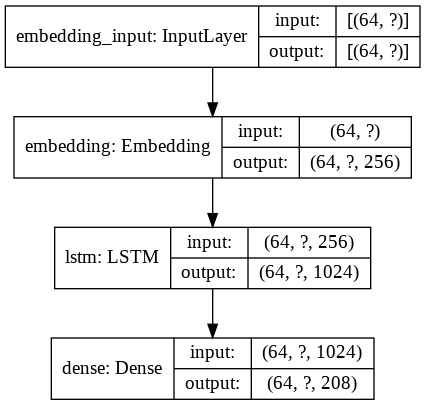

In [28]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    to_file='model.png'
)

In [29]:
def loss(labels, logits):
    entropy = tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )
    
    return entropy

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

In [30]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

In [31]:
# Create a checkpoints directory.
checkpoint_dir = '/content/drive/My Drive/Checkpoints3'
#checkpoint_dir = 'tmp/checkpoints'
#os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

In [32]:
EPOCHS = 50
INITIAL_EPOCH = 1
STEPS_PER_EPOCH = 1500

print('EPOCHS:          ', EPOCHS)
print('INITIAL_EPOCH:   ', INITIAL_EPOCH)
print('STEPS_PER_EPOCH: ', STEPS_PER_EPOCH)

EPOCHS:           50
INITIAL_EPOCH:    1
STEPS_PER_EPOCH:  1500


In [33]:
def initial_epoch_from_latest_checkpoint():
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)

    if not latest_checkpoint_path:
        print('Latest checkpoint was not found. Starting from epoch #0')
        return 0

    print('latest_checkpoint_path: ', latest_checkpoint_path)

    latest_checkpoint_name = os.path.split(latest_checkpoint_path)[-1]
    print('latest_checkpoint_name: ', latest_checkpoint_name)

    latest_checkpoint_num = latest_checkpoint_name.split('_')[-1]
    print('latest_checkpoint_num: ', latest_checkpoint_num)

    return int(latest_checkpoint_num)

In [34]:
def model_weights_from_latest_checkpoint(model):
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)

    if not latest_checkpoint_path:
        print('Latest checkpoint was not found. Using model as is.')
        return model

    print('latest_checkpoint_path: ', latest_checkpoint_path)

    model.load_weights(latest_checkpoint_path)

    return model

In [35]:
def download_latest_checkpoint(zip_only=True):
    latest_checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
    latest_checkpoint_name = os.path.split(latest_checkpoint_path)[-1]
    latest_checkpoint_zip_name = latest_checkpoint_name + '.zip'
    
    print('latest_checkpoint_path: ', latest_checkpoint_path)
    print('latest_checkpoint_name: ', latest_checkpoint_name)
    print('---\n')

    print('Checkpoint files:')
    with zipfile.ZipFile(latest_checkpoint_zip_name, mode='w') as zip_obj:
        for folder_name, subfolders, filenames in os.walk(checkpoint_dir):
            for filename in filenames:
                if filename.startswith(latest_checkpoint_name):
                        print('  - ' + filename)
                        file_path = os.path.join(folder_name, filename)
                        zip_obj.write(file_path, os.path.basename(file_path))
    print('---\n')
    print('Zipped to: ', latest_checkpoint_zip_name)

    if not zip_only:
        files.download(latest_checkpoint_zip_name)

In [36]:
def unzip_checkpoint(checkpoint_zip_path):
    if not os.path.exists(checkpoint_zip_path):
        print('Cannot find a specified file')
        return

    os.makedirs(checkpoint_dir, exist_ok=True)
    with zipfile.ZipFile(checkpoint_zip_path, 'r') as zip_obj:
        zip_obj.extractall(checkpoint_dir)

    %ls -la ./tmp/checkpoints

In [37]:
history = {}
history = {} if not history else history
print(history)

{}


In [39]:
for i in range(2):
   INITIAL_EPOCH  = initial_epoch_from_latest_checkpoint()
   EPOCHS_DELTA = 1
   EPOCHS = INITIAL_EPOCH + EPOCHS_DELTA
   STEPS_PER_EPOCH = 1500

   print('\n')
   print('INITIAL_EPOCH:   ', INITIAL_EPOCH)
   print('EPOCHS_DELTA:    ', EPOCHS_DELTA)
   print('EPOCHS:          ', EPOCHS)
   print('STEPS_PER_EPOCH: ', STEPS_PER_EPOCH)

 
   model = model_weights_from_latest_checkpoint(model)
   history[INITIAL_EPOCH] = model.fit(
       x=dataset_train,
       epochs=EPOCHS,
       steps_per_epoch=STEPS_PER_EPOCH,
       initial_epoch=INITIAL_EPOCH,
       callbacks=[
           checkpoint_callback,
           early_stopping_callback
       ]
   )

   model_name = 'recipe_generation_rnn_raw_' + str(INITIAL_EPOCH) + '.h5'
   model.save(model_name, save_format='h5')

   download_latest_checkpoint(zip_only=True)

print(history)
model_name = 'recipe_generation_rnn_raw.h5'
model.save(model_name, save_format='h5')

latest_checkpoint_path:  /content/drive/My Drive/Checkpoints3/ckpt_65
latest_checkpoint_name:  ckpt_65
latest_checkpoint_num:  65


INITIAL_EPOCH:    65
EPOCHS_DELTA:     1
EPOCHS:           66
STEPS_PER_EPOCH:  1500
latest_checkpoint_path:  /content/drive/My Drive/Checkpoints3/ckpt_65
Epoch 66/66
1500/1500 [==============================] - 1463s 975ms/step - loss: 0.1852
latest_checkpoint_path:  /content/drive/My Drive/Checkpoints3/ckpt_66
latest_checkpoint_name:  ckpt_66
---

Checkpoint files:
  - ckpt_66.data-00000-of-00001
  - ckpt_66.index
---

Zipped to:  ckpt_66.zip
latest_checkpoint_path:  /content/drive/My Drive/Checkpoints3/ckpt_66
latest_checkpoint_name:  ckpt_66
latest_checkpoint_num:  66


INITIAL_EPOCH:    66
EPOCHS_DELTA:     1
EPOCHS:           67
STEPS_PER_EPOCH:  1500
latest_checkpoint_path:  /content/drive/My Drive/Checkpoints3/ckpt_66
Epoch 67/67
1500/1500 [==============================] - 1465s 977ms/step - loss: 0.1851
latest_checkpoint_path:  /content/drive/My 

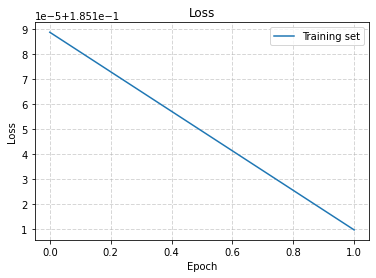

In [40]:
def render_training_history(training_history):
    if 'history' in training_history:
        loss = training_history.history['loss']
    else:
        loss = []
        for initial_epoch in training_history:
            loss += training_history[initial_epoch].history['loss']

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

render_training_history(history)

In [41]:
tf.train.latest_checkpoint(checkpoint_dir)

'/content/drive/My Drive/Checkpoints3/ckpt_67'

In [42]:
vocab_size = VOCABULARY_SIZE
embedding_dim = 256
rnn_units = 1024

In [43]:
simplified_batch_size = 1

model_simplified = build_model(vocab_size, embedding_dim, rnn_units, simplified_batch_size)
model_simplified.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model_simplified.build(tf.TensorShape([simplified_batch_size, None]))

model_simplified.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            53248     
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 1024)           5246976   
_________________________________________________________________
dense_1 (Dense)              (1, None, 208)            213200    
Total params: 5,513,424
Trainable params: 5,513,424
Non-trainable params: 0
_________________________________________________________________


In [44]:
model_simplified.input_shape

(1, None)

In [67]:
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    
    padded_start_string = STOP_WORD_INGREDIENTS + '• ' + start_string
    input_indices = np.array(tokenizer.texts_to_sequences([padded_start_string]))

    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1, 0].numpy()

        # We pass the predicted character as the next input to the model along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)
        
        next_character = tokenizer.sequences_to_texts(input_indices.numpy())[0]

        if(next_character != STOP_SIGN):
            text_generated.append(next_character)

    return (padded_start_string + ''.join(text_generated))

In [68]:
def generate_combinations(model, recipe_length, try_letters, try_temperature):

    for letter in try_letters:
        for temperature in try_temperature:
            generated_text = generate_text(
                model,
                start_string=letter,
                num_generate = recipe_length,
                temperature=temperature
            )
    return generated_text

In [69]:
#input_chars = ['', '\n', 'A', 'B', 'C', 'Apple']
#temperatures = [1.0, 0.8, 0.4, 0.2]

recipe_length = 1000
input_chars = ['flour']
temperatures = [1.0]
output = generate_combinations(model_simplified, recipe_length, input_chars, temperatures)
print(output)



INGREDIENTS

• flour
• salt
• pepper
• celery_salt
• onions
• garlic
• flour
• ribs
• soup
• sauce
• juices
• onions
• cornstarch
• water
• sauce
• salt
• pepper
• serving


INSTRUCTIONS

•cut 4 shrimp sheets in half . arrange chillies in an aluminum parcel . refrigerate for about 1/2 hr , up to 24 hours . melt 2 tbsp . butter in non stick 8 10 nonstick skillet heat up enough water for sauce . . . heat oil in large kettle . gently stir fry over medium low heat for approximately 10 to 15 minutes . add garlic and heat until garlic is golden . add prawns and remaining salt and pepper . stir in tomatoes , chicken broth , stock and tinned ham . add fig strips to pot . bring to a boil , lower heat and simmering , stirring often , until liquid reduces . combine sherry and cornstarch and fold in light sour cream . pass into crumb mixture . serve at room temperature as an appetizer .



In [70]:
import random

In [71]:
f= open("generated_recipes.txt","w+")

for i in range(100):
    n = random.randint(0, len(ingredients) - 1)

    recipe_length = 1000
    input_chars = [ingredients[n]]
    temperatures = [1.0]
    output = generate_combinations(model_simplified, recipe_length, input_chars, temperatures)
    
    if(output != None):
        print("input: ", ingredients[n])
        print("\n\n")
        print(output)
        print("\n\n")
        f.write(output)
        f.write("\n\n")

f.close() 

input:  jam





INGREDIENTS

• jam
• tart_shells
• strawberries
• raspberries
• molasses


INSTRUCTIONS

•place crumbs in an even layer in an ovenproof dish . bake in the middle of the oven . allow to stand , covered in a double foil for 30 minutes . press finishing sauce , or bottom of glasses if desired . whip to 200c or egg white . ladle soup into bowls and top with some more mint at once .




input:  eggs





INGREDIENTS

• eggs
• beef
• mixture
• salmon
• mixture
• bread
• paprika
• fish
• mustard
• creme_fraiche
• chives
• salt
• pepper
• oil
• sausage
• fish
• fish
• plastic
• sauce
• batter
• onion
• parsley
• lemon_juice
• salt
• pepper
• fillets
• sauce
• fish
• gravy
• butter
• fish


INSTRUCTIONS

•chop fish and place in cold skillet . cover salmon with salmon and lay in salt . cook , mixing together for 10 40 minutes . in a small pan , warm the frozen milk and the vinegar . heat . season again and when it is finished brown , separating them with a rubber , well heated b